In [ ]:
!pip install rdkit-pypi
!pip install XlsxWriter
!pip install gdown
!pip install matminer
!pip install skorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.3/671.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.1/802.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_validate, train_test_split
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, GridSearchCV

from matminer.datasets import load_dataset
from matminer.featurizers.conversions import StructureToComposition
from matminer.featurizers.composition import ElementProperty
from skorch import NeuralNetRegressor

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline


In [ ]:
#  URL with the shareable link to your Google Sheets document
google_sheets_url = "https://docs.google.com/spreadsheets/d/1jdoToY-lbibVxI0mcGwPf6LkkI786JJQwDWVzQQ7Glo/edit#gid=159703025"

# read data
df = pd.read_csv(f"{google_sheets_url.replace('/edit#gid=', '/gviz/tq?tqx=out:csv&gid=')}")

# Now, 'df' contains the data from your Google Sheets document
df

,Flow Tag Date,EL_Solar_BusBarn_Total_KW
0,14-May-11 00:00:00,0.000000
1,14-May-11 01:00:00,0.000000
2,14-May-11 02:00:00,0.000000
3,14-May-11 03:00:00,0.000000
4,14-May-11 04:00:00,0.000000
...,...,...
108321,21-Sep-23 09:00:00,5.203238
108322,21-Sep-23 10:00:00,7.773371
108323,21-Sep-23 11:00:00,11.066359
108324,21-Sep-23 12:00:00,4.890486


In [ ]:
df.loc[df['EL_Solar_BusBarn_Total_KW'] > 100, 'EL_Solar_BusBarn_Total_KW'] = 0

# Save the modified DataFrame back to a CSV file
df.to_csv('modified_file.csv', index=False)
# Convert the 'Date' column to datetime format

df

,Flow Tag Date,EL_Solar_BusBarn_Total_KW
0,14-May-11 00:00:00,0.000000
1,14-May-11 01:00:00,0.000000
2,14-May-11 02:00:00,0.000000
3,14-May-11 03:00:00,0.000000
4,14-May-11 04:00:00,0.000000
...,...,...
108321,21-Sep-23 09:00:00,5.203238
108322,21-Sep-23 10:00:00,7.773371
108323,21-Sep-23 11:00:00,11.066359
108324,21-Sep-23 12:00:00,4.890486


In [ ]:
repeat_mask = df.duplicated('EL_Solar_BusBarn_Total_KW', keep=False)

# Replace repeat values with 0
df.loc[repeat_mask,'EL_Solar_BusBarn_Total_KW' ] = 0

# Save the modified DataFrame back to a CSV file
df.to_csv("modified_file.csv", index=False)

df


Forecasting model

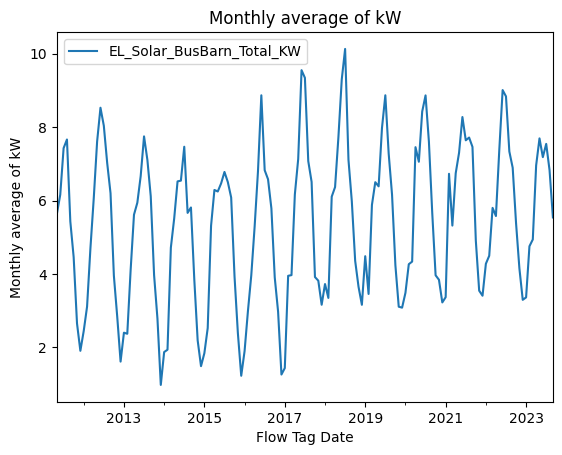

In [ ]:
df['Flow Tag Date'] = pd.to_datetime(df['Flow Tag Date'])  # Convert 'Date' column to datetime
df.set_index('Flow Tag Date', inplace=True)  # Set 'Date' as the index

# Now you can resample the DataFrame by month
df = df.resample("M").mean().dropna(axis="index", how="any")

# Plot the data
df.plot()
plt.ylabel("Monthly average of kW")
plt.title("Monthly average of kW")
plt.show()

In [ ]:
X = (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)
y = df["EL_Solar_BusBarn_Total_KW"].to_numpy()

In [ ]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

In [ ]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

In [ ]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)


In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [ ]:
kW_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
kW_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor


y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=kW_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ga

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [ ]:
import datetime
today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=2011, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

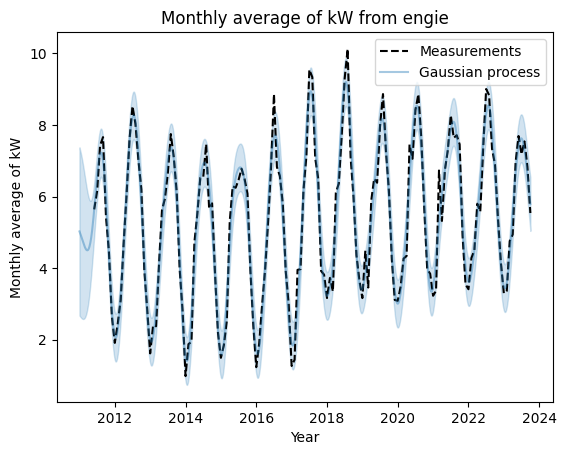

In [ ]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of kW")
_ = plt.title(
    "Monthly average of kW from engie and forecasst"
)

neural network model

In [ ]:
y = df[['EL_Solar_BusBarn_Total_KW']].values
X = df[['Flow Tag Date']].values
print(X.shape, y.shape)

(108326, 1) (108326, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(43330, 1) (43330, 1)
(64996, 1) (64996, 1)


In [ ]:
print(X_train.dtype)
print(y_train.dtype)
print(X_test.dtype)
print(y_test.dtype)

datetime64[ns]
float64
datetime64[ns]
float64


In [ ]:
##bad model down here

X_transform = StandardScaler().fit(X_train)
X_train = torch.from_numpy(X_transform.transform(X_train)).float()
X_test = torch.from_numpy(X_transform.transform(X_test)).float()
y_transform = StandardScaler().fit(y_train)
y_train = torch.from_numpy(y_transform.transform(y_train)).float()
y_test = torch.from_numpy(y_transform.transform(y_test)).float()

In [ ]:
print(X_train)
print(y_train)

tensor([[ 0.9718],
        [ 1.4303],
        [-1.1905],
        ...,
        [ 0.2364],
        [-0.6700],
        [ 0.6678]])
tensor([[-0.5215],
        [-0.5215],
        [-0.5215],
        ...,
        [-0.5215],
        [ 0.0793],
        [-0.5056]])


In [ ]:
input_dim = X_train.shape[-1]
output_dim = 1
hidden_dim = 512
model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim))
# Check if CUDA (GPU) is available; if not, use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device.
model.to(device)

regr = NeuralNetRegressor(model, batch_size=64, max_epochs=50, lr=.0001, device=device)
regr.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0146        0.9407  3.2149
      2        1.0100        0.9405  3.8959


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  ),
)

In [ ]:
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.BatchNorm1d(hidden_dim),  # Batch normalization layer
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.BatchNorm1d(hidden_dim),  # Batch normalization layer
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device.
model.to(device)

regr = NeuralNetRegressor(model, batch_size=64, max_epochs=50, lr=.0001, device=device)
regr.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0203        0.9405  1.8319


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
  ),
)

In [ ]:
input_dim = X_train.shape[-1]
output_dim = 1
hidden_dim = 512
model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim))
# Check if CUDA (GPU) is available; if not, use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device.
model.to(device)

regr = NeuralNetRegressor(model, batch_size=64, max_epochs=50, lr=.0001, device=device)
regr.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9913        1.0177  1.2133
      2        0.9907        1.0177  1.1596
      3        0.9906        1.0176  1.1443
      4        0.9905        1.0176  1.1626
      5        0.9904        1.0175  1.1139
      6        0.9904        1.0175  1.3482
      7        0.9903        1.0175  1.6682
      8        0.9903        1.0174  1.3445
      9        0.9902        1.0174  1.1721
     10        0.9902        1.0174  1.1695
     11        0.9901        1.0173  1.1017
     12        0.9901        1.0173  1.2191
     13        0.9900        1.0173  1.0797
     14        0.9900        1.0172  1.1441
     15        0.9900        1.0172  1.1160
     16        0.9899        1.0172  1.1644
     17        0.9899        1.0172  1.5701
     18        0.9899        1.0171  1.4574
     19        0.9898        1.0171  1.1418
     20        0.9898        1.0171  1.1599
     21        0.9898        1.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  ),
)

Ali's section


In [ ]:
ali_df = filtered_df[filtered_df['EL_Solar_BusBarn_Total_KW'] > 0.0001]
ali_df
new_labels = [f"{i + 1}" for i in range(len(ali_df))]
ali_df.index = new_labels

# Save the modified DataFrame to a new CSV file
ali_df.to_csv("modified.csv")
ali_df = ali_df
ali_df


,Flow Tag Date,EL_Solar_BusBarn_Total_KW
1,2011-05-14 07:00:00,0.044322
2,2011-05-14 08:00:00,0.201312
3,2011-05-14 09:00:00,0.223929
4,2011-05-14 10:00:00,0.645141
5,2011-05-14 11:00:00,1.391401
...,...,...
52930,2023-09-21 09:00:00,5.203238
52931,2023-09-21 10:00:00,7.773371
52932,2023-09-21 11:00:00,11.066359
52933,2023-09-21 12:00:00,4.890486


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(ali_df, *['EL_Solar_BusBarn_Total_KW'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(ali_df, *['EL_Solar_BusBarn_Total_KW'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(ali_df, *['Flow Tag Date', 'EL_Solar_BusBarn_Total_KW', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(ali_df, *['Flow Tag Date', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(ali_df, *['Flow Tag Date', 'EL_Solar_BusBarn_Total_KW', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(ali_df, *['Flow Tag Date', 'count()', None], **{})
chart

In [ ]:
#Imports // comments on what each import is used for
import os
import requests  # For making HTTP requests to a specified URL
from bs4 import BeautifulSoup  # For parsing HTML and extracting the information we need
import pandas as pd  # For creating and manipulating data in table (DataFrame) format
from urllib.parse import urljoin  # For joining base URL and relative URL correctly

# url info scrapping, excel below is where information is getting scrapped
google_sheet_url = "https://docs.google.com/spreadsheets/d/1jdoToY-lbibVxI0mcGwPf6LkkI786JJQwDWVzQQ7Glo/export?format=csv"
url = google_sheet_url  #base url
df_google_sheet = pd.read_csv(google_sheet_url) # reads data from excel into dataframe
print(df_google_sheet.head()) #prints first few rows to check data

#empty list where the information from the excel is getting stored
data = []

# Start a loop that will continue until we break out of it
while True:
    # Send a GET request to the specified URL and store the response in a variable 'r'
    r = requests.get(url)

    # Check if the request was successful (status code 200)
    if r.status_code != 200:
        # If not successful, print an error message and break out of the loop
        print(f"Failed to retrieve data from {url}")
        break

    # Parse the HTML content of the page with BeautifulSoup
    soup = BeautifulSoup(r.text, 'lxml')

    # Loop through each table row on the page
    for row in soup.find_all('tr'):
        # Loop through each link in the table row
        for a in row.find_all('a'):
            # Extract and clean the text and link from the anchor tag
            polymer_class = a.text.strip()
            link = a.get('href')

            # Append the extracted data as a dictionary to the 'data' list
            data.append({"Polymer Class": polymer_class, "Link": link})

    # Find the last link on the page (usually the 'Next' or 'More' link)
    all_links = soup.find_all('a')
    if all_links:
        last_url = all_links[-1]

        # Check if there are more pages to scrape
        if "Next" in last_url.text or "More" in last_url.text:
            # If yes, update the URL to the next page and continue the loop
            url = urljoin(google_sheet_url, last_url.get('href'))
        else:
            # If no more pages, break out of the loop
            break
    else:
        # If no anchor tags are found, break out of the loop
        print("No anchor tags found on the page.")
        break

df = pd.DataFrame(data)
df.to_excel("polymer_data.xlsx", index=False)

# defines function of conversion effiency
def calculate_conversion_efficiency(kwh_per_square_meter, kwh, square_meter):
    """
      kwh / (kwh_per_square_meter * square_meter) - formula for conversion effiency
    - Conversion Efficiency= Solar Irradiance (kWh/m^2)*Total Area of Solar Array(m^2) Total Energy Produced (kWh)
​

    """
    # use of formula below in a result
    return kwh / (kwh_per_square_meter * square_meter)

# calls the function of conversion effiency
result = calculate_conversion_efficiency(5, 100, 100)
#prints the conversion effiency
print("The conversion efficiency is", result)
'''
To Do List:
1. For every day that doesnt have a value of energy less than 0+ - 2 delete
2. For every day that has the value above 125, cut that too
3. For every day that repeats the same number more than 4 times cut that too
4. Find conversion factors for hours, days,
5.
'''

             Flow Tag                 Unnamed: 1
0                Date  EL_Solar_BusBarn_Total_KW
1  14-May-11 00:00:00                          0
2  14-May-11 01:00:00                          0
3  14-May-11 02:00:00                          0
4  14-May-11 03:00:00                          0
No anchor tags found on the page.
The conversion efficiency is 0.2
